In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import pi

from astropy.cosmology import FlatLambdaCDM as FlatLambdaCDM_ap
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.LensModel.lens_model import LensModel
import lenstronomy.Util.param_util as param_util
from matplotlib.colors import CenteredNorm
import matplotlib.pyplot as plt
import numpy as np
import torch

from caustic.cosmology import FlatLambdaCDMCosmology
from caustic.lenses import SIE, MultiplaneLens
from caustic.utils import get_meshgrid

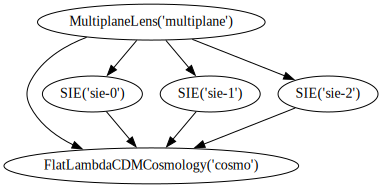

In [3]:
# Setup
n_pix = 100
res = 0.05
fov = res * n_pix
thx, thy = get_meshgrid(res, n_pix, n_pix, dtype=torch.float32)
z_s = torch.tensor(1.5, dtype=torch.float32)
cosmology = FlatLambdaCDMCosmology("cosmo")
cosmology.to(dtype=torch.float32)

# Parameters
xs = [
    [0.5, 0.9, -0.4, 0.9999, 3 * pi / 4, 0.8],
    [0.7, 0.0, 0.5, 0.9999, -pi / 6, 0.7],
    [1.1, 0.4, 0.3, 0.9999, pi / 4, 0.9],
]
x = torch.tensor([p for _xs in xs for p in _xs], dtype=torch.float32)

lens = MultiplaneLens(
    "multiplane", cosmology, [SIE(f"sie-{i}", cosmology) for i in range(len(xs))]
)
lens.get_graph()

In [4]:
ra_at_xy_0, dec_at_xy_0 = ((-fov + res) / 2, (-fov + res) / 2)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * res
kwargs_pixel = {
    "nx": n_pix,
    "ny": n_pix,  # number of pixels per axis
    "ra_at_xy_0": ra_at_xy_0,
    "dec_at_xy_0": dec_at_xy_0,
    "transform_pix2angle": transform_pix2angle,
}
pixel_grid = PixelGrid(**kwargs_pixel)
thx_ls, thy_ls = pixel_grid.coordinate_grid(n_pix, n_pix)

kwargs_ls = []
for _xs in xs:
    e1, e2 = param_util.phi_q2_ellipticity(phi=_xs[4], q=_xs[3])
    kwargs_ls.append(
        {
            "theta_E": _xs[5],
            "e1": e1,
            "e2": e2,
            "center_x": _xs[1],
            "center_y": _xs[2],
        }
    )

cosmo_ap = FlatLambdaCDM_ap(cosmology.h0.value, cosmology.Om0.value, Tcmb0=0)
lens_ls = LensModel(
    lens_model_list=["SIE" for _ in range(len(xs))],
    z_source=z_s.item(),
    lens_redshift_list=[_xs[0] for _xs in xs],
    cosmo=cosmo_ap,
    multi_plane=True,
)

In [5]:
alpha_x, alpha_y = lens.alpha(thx, thy, z_s, lens.x_to_dict(x))
alpha_x_ls, alpha_y_ls = lens_ls.alpha(thx_ls, thy_ls, kwargs_ls)

True
tensor(0.0029, dtype=torch.float64)
True
tensor(0.0031, dtype=torch.float64)


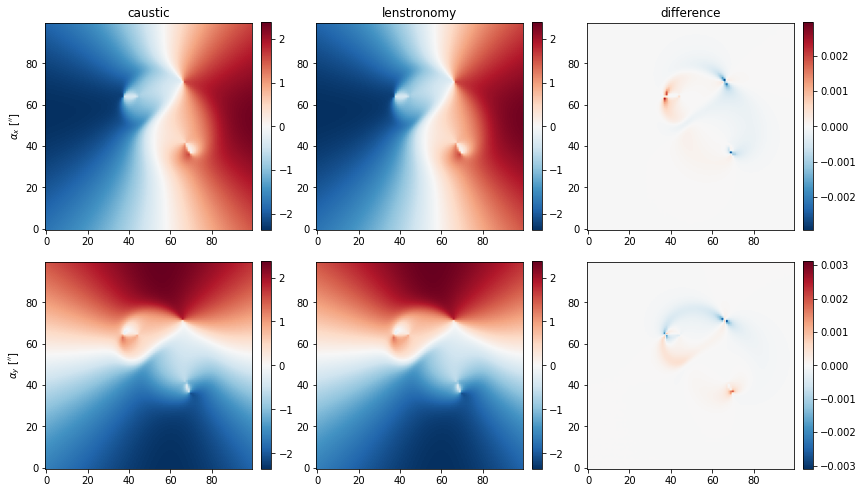

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
kwargs_imshow = {"origin": "lower", "cmap": "RdBu_r"}
for alpha, alpha_ls, axs in zip((alpha_x, alpha_y), (alpha_x_ls, alpha_y_ls), axes):
    ax = axs[0]
    im = ax.imshow(alpha, norm=CenteredNorm(), **kwargs_imshow)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax = axs[1]
    im = ax.imshow(alpha_ls, norm=CenteredNorm(), **kwargs_imshow)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax = axs[2]
    im = ax.imshow(alpha - alpha_ls, norm=CenteredNorm(), **kwargs_imshow)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    print(np.allclose(alpha, alpha_ls, 0, 5e-3))
    print((alpha - alpha_ls).abs().max())

axes[0, 0].set_title("caustic")
axes[0, 1].set_title("lenstronomy")
axes[0, 2].set_title("difference")
axes[0, 0].set_ylabel(r"$\alpha_x$ [$''$]")
axes[1, 0].set_ylabel(r"$\alpha_y$ [$''$]")

fig.tight_layout()

Compare comoving distances

Text(0, 0.5, 'caustic - lenstronomy/astropy')

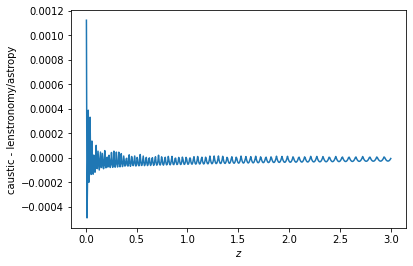

In [7]:
zs = torch.linspace(0, 3, 500)
plt.plot(
    zs,
    (cosmology.comoving_dist(zs) - cosmo_ap.comoving_distance(zs).value / 1e2)
    / cosmology.comoving_dist(zs),
)
plt.xlabel(r"$z$")
plt.ylabel("caustic - lenstronomy/astropy")